# Doc2Vecのhyper parameter tuning（setup1）

### 目的
Doc2Vecのhyper parameterをTuningする。

### データ
前処理１を施したlivedoor news data　　
（"check_preproc1.ipynb"）

### 手段
1. doc2vecのhyper paramterを設定する。
2. doc2vecをトレーニングする。
3. evaluation_w_category_setup1.ipynbにある通り、カテゴリ予測の教師あり学習で（カテゴリ予測の）モデル精度を測定する。
    - モデル精度が高ければ、input data (= doc2vecのvector)の情報量が高い、と推定できる。
    - モデル精度の高いhyper parameterを採用する。

### パラメータ
Doc2Veｃのパラメータの説明は、下のcellを参照。
**固定するパラメータ**
- アルゴリズムはPV-DBOWに固定。  
    - https://arxiv.org/abs/1607.05368 より、DMPVよりDBOWの方が安定して動作し、精度として問題ないようなので。
- negative samplingを使い、使用する際の値も固定（negative_sample=5, ns_exponent=0.75）。
    - negative samplingは上記の値に設定しておけば、ほぼtuningは不要なので。

**この実験で調査するパラメータ**
1. epochs
2. min_alpha（alphaは0.025に固定）
3. sample
4. min_count
5. window
6. vector_size

### 参考資料
- original paper:  https://cs.stanford.edu/~quocle/paragraph_vector.pdf
- 追試 paper:  https://arxiv.org/abs/1607.05368

## 実験結果のまとめ
個別の結果の詳細は下記参照。ここでは、それらの結果をまとめて考察を行う。  
(以下、教師あり学習の精度(accuracy)で評価を行う際、誤差〜1%としている)。


### a. epoch
epochを大きくすることで、**大きな改善**が見られた。  
今回のデータは、**~1e+4文書とデータ量が少ないため、epochをdefaultより多く回す必要**があるようだ。  
おそらく十分なデータ量（~1M docs)があれば、defaultの5回でも十分だと推測される。  
ある程度の値（ここでは20~30)でサチるので、あまり高く上げる必要はない（上げた分、線形にトレーニング時間がかかる）。   
ここでは**epoch=30**を採用。

| epoch　|　5　|　20　|　30　|　50　|
|:----|-----:|-----:|-----:|-----:|
| accuracy | 0.77 | 0.88 | 0.89 | 0.89 |

### b. min alpha
1e-3~1e-5の常識的な範囲で動かす分には、大きな違いは見られなかった。  
ここでは**min_alpha=1e-4**を採用。

| min_alpha　|　1e-3　|　1e-4　|　1e-5　|
|:----|-----:|-----:|-----:|
| accuracy | 0.88 | 0.89 | 0.89 |

### c. sample
1e-1~1e-5までほとんど変化は見られなかった。一方、1e-6では精度が下がった。  
頻出頻度が（ある程度）低い単語にまでsub-sampleする事になり、   
重要な情報量が削減されたのだと考えられる。  

[追試　paper]では、sub-sample=1e-5と設定されている。  
paperのように文書量が多ければ、sampleの値を低く設定してもOKだと思われる。  
ここでは文章量が少ないことを考慮して、**sample=1e-3**を採用。

| sample　|　1e-1　|　1e-2　|　1e-3　|　1e-4　|　1e-5　|　1e-6　|
|:----|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.87 | 0.87 | 0.88 | 0.87 | 0.88 | 0.81 |

### d. min count
min_countが大きくなるにつれ、（数%だが）精度が上がってく。  
1→5では精度が上がり、5→200ではほぼ精度に変化はない(多少上がったかもだが、誤差の範囲内？)。  
1000に設定すると、精度は下がる。  

思った以上に、min_countが高くても精度が下がらない。むしろ精度は  
上がっているくらい。頻出頻度の低い単語はノイズとなり、vectorの学習を  
妨げるのだと考えられる。   

一方でmin_count=200などは明らかに高すぎる設定値（全文書が1万程度しかないことを考慮すると）。  
なぜこの場合でも  精度が高く保たれているのかは不明。。  
教師あり学習のラベル付けが、複数文書で頻出している単語で判断しているとすると、  
頻出数が少ない単語は学習しなくても、（ラベル付けの）精度には影響が小さいのかもしれない。

min_count=1だとノイズのため、精度が低くなるのは確かで、これは  
**前処理をしっかりとすることが大事**だ、ということも示している、かも？  

"evaluation_w_category_1-default.ipynb"で考察した通り、教師ありモデル精度とdoc2vecの表現精度  
は（良い相関はあるものの）必ずしも一致しない。  
min_countを大きくしすぎると情報量が少なくなりそうなので、ここでは**min_count=5を採用**。


| min_count　|　1 |　2 |　5 |　10 |　20 |　40 | 100 | 200 | 1000 |
|:----|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.88 | 0.89 | 0.90 | 0.90 | 0.91 | 0.91 | 0.91 | 0.91 | 0.86 |

### d. window size
予想外だったが、window_sizeは精度にほぼ影響しない。  
DBOWだからかもしれない。文書にどんな種類の単語あるのかわかれば良く、  
文脈情報の取得が重要でないためwindowの影響が少ないのかも。  
[追試 paper]に従い、ここでは**window=15を採用**。

| window　|　2 | 4 | 8 | 15 | 30 | 50 |
|:----|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.90 | 0.90 | 0.90 | 0.90 | 0.90 | 0.90 |

### f. vector size
予想通り、vector sizeが小さすぎると情報を表現できなくなるため、モデル精度が低くなる。  
今回の場合は、50~100程度あれば十分なようだ。  
逆に>200になると、（おそらく)情報量に対してvector sizeが大きくなりすぎるため、  
sparse成分が多くなると思われる。その結果、**教師あり学習の学習曲線が少し不安定**になっている。  

データセットに適切なvector sizeを選ぶことが大事だということがわかる。  
ここでは、**vector_size=100を採用**。

| vector_size　|　20 |　50 |　100 |　200 |　300 |　400 |
|:----|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.85 | 0.90 | 0.91 | 0.91 | 0.90 | 0.90 |

## まとめ
上記a~fで採用した値で学習すると、
- default(最適化前): accuracy=0.77
- opt(最適化後)：　accuracy=0.91
と大きく精度が上がった。

やはり**hyper parameter tuningは重要**。  
- 今回、一番大きな影響があったのは**epoch**。文章量が少ない時は、epochを大きく設定するのが良い。
- **min_count, vector_size, sample**も、適切に設定することが大事。データに依存するので、都度tuningする必要あり。
- **min_alpha, window_size**は、だいたい常識的な範囲に設定すれば、精度に大きな影響はない。

## Doc2Vecのパラメータの説明

| タイプ | パラメータ名 | 説明 |　備考　|
|:---|:---|:---|:---|
|**アルゴリズム**
|| dm |1: dm,  0: dbow <br>dm: 単語の順序も勘案される。<br>dbow: 単語の順序は無視される。 | original paper:  https://cs.stanford.edu/~quocle/paragraph_vector.pdf <br> 追試 paper:  https://arxiv.org/abs/1607.05368 <br>[original]だと、dmの方が良いとされるが、[追試]だと、dbowの方が良いとされてる。<br>どちらが精度が良いかはわからないが、<br>dbowの方がstableで学習時間が少ないのは確かっぽい。 |
|| vector_size|outputされるベクトルの次元数|次元数が多い方が表現力はあがるが、そのためにはデータ情報もたくさん必要。<br>[追試]だと、1Mのデータに対して300次元に設定されてる。|
||window|window size|Word2Vecのskip gramと似た原理|
|**ボキャブラリー作成**
||min_count|このcount以下しか出ていないwordは無視する。|count = 全てのdocumentのword毎のcountのsum|
||sample|高頻度で出ているwordを、ランダムにdown-samplingする。|p = (f - t) / f - sqrt(t / f), where f=freq of words, t=threshold (= "sample" parameter)<br>   t=0なら、down samplingなし<br>   t > 0ならf > tのwordsに対して、（その頻度に応じて）vocabularyを作る際にdown-samplingする。<br> doc2vecのdocumentでは、(0, 1e-5)の範囲が推奨されている。
||trim_rule|自作した関数を受け渡すことで<br>「この単語を消したい・残したい」といった指定を細かくできる。|関数の引数は、(word, count, min_count) <br>Noneの場合、デフォルト（count >= min_count）が適用される。
||max_vocab_size|vocablary sizeの上限の数|もしこの上限値を超えた場合、freqの少ないwordから消していく。<br>（英単語の場合)10M単語で~1GB RAMが必要|
|**Training計算量を減らす<br>ためのパラメータ**|training計算量を減らすために、<br>hierarchical softmax（hs=1）<br>negative sampling (hs=0 & netaive>0)<br>のいずれかを使う。<br> ＃hs=0 & negative=0なら<br>何もしない（お薦めしない）。
||hs|hierarchical softmax (階層ソフトマックス)|negative samplingを使う方が普通?|
||negative|Negative samplingに使う単語数（0ならnegative samplingしない）|5-20でOK。[追試]では5が使われていた。|
||ns_exponent|negative samplingで使用する単語の分布を決めるパラメータ|Word2Vecのoriginal paperでは0.75が推奨されている。|
|**Training**
||alpha, min_alpha|alpha -> min_alphaに、learning rateが線形に落ちていく。|[追試]によると、alphaを小さめに設定（alpha=1e-2 → 1e-4）して、<br>epoch数を多め（500~1000)にすると精度が良くなったらしい。|
||epoch|イタレーション数||
|**その他**
||woker|トレーニングする時に使用するthread数| マルチコアのPCなら、この数に合わせることで早くなる）|
||dbow_words|1なら、トレーニング時に（doc vectorに加えて）word vectorも作る。|doc vectorだけ必要なら、word vectorは不要。<br>0に設定すれば、トレーニング時間を節約できる。|

In [1]:
import pickle
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
import psutil
import yaml

import os, sys
sys.path.append(os.path.pardir)
from utils import evaluation_docs


class ExpPar(object):
    def __init__(self, tag_pp, tag_setup):
        fn_tagged_words_list = './preproc_data/words_list_mecab_%s.pickle' % tag_pp
        fn_category_map = './preproc_data/category_map_%s.pickle' % tag_pp
        parfile = './params/doc2vec_par_%s.yaml' % tag_pp
        
        self.fn_model = './model/doc2vec_%s_setup%s.model' % (tag_pp, tag_setup)
        self.tagged_words_list = pickle.load(open(fn_tagged_words_list, 'rb'))
        self.dic_category_map = pickle.load(open(fn_category_map, 'rb'))
        self.params = yaml.load(open(parfile))[tag_setup]

    def train_model(self, save=True, show=True):
        opt_parnames =\
            ['vector_size', 'window', 'min_count', 'sample', 'alpha', 'min_alpha', 'epochs']
        model = Doc2Vec(documents=self.tagged_words_list, worker=psutil.cpu_count(), **self.params)

        if show:
            print('\nDoc2Vec training parameters:')
            for parname in opt_parnames:
                print('  %s: %s' % (parname, self.params[parname]))
        if save:
            model.save(self.fn_model)
        return model

/Users/usr0102292/.pyenv/versions/anaconda3-5.2.0/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Default
デフォルトのセットアップ（前処理１で処理したベクトルデータ）で、Doc2Vecをトレーニング。


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 5

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.7561170771319707
  Test accuracy: 0.7662782725853166
  Epoch: 392


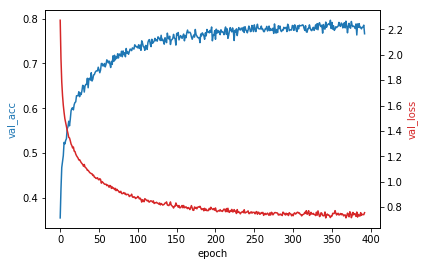

CPU times: user 1min 15s, sys: 7.35 s, total: 1min 22s
Wall time: 41.8 s


In [2]:
%%time
tag_pp = 'pp1'
tag_setup = '1-default'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model(save=False)
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)

In [9]:
%%html
<style>table {float: left}</style>

## a. epoch

| epoch　|　5　|　20　|　30　|　50　|
|:----|-----:|-----:|-----:|-----:|
| accuracy | 0.77 | 0.88 | 0.89 | 0.89 |



Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 20

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.416043585073139
  Test accuracy: 0.8759424261151314
  Epoch: 255
CPU times: user 2min 26s, sys: 6.79 s, total: 2min 33s
Wall time: 1min 7s


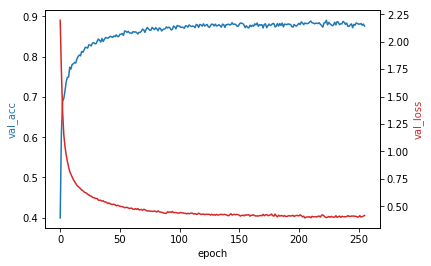

In [3]:
%%time
tag_pp = 'pp1'
tag_setup = '1-a1'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 50

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.38953534824706004
  Test accuracy: 0.8855380401209334
  Epoch: 188
CPU times: user 5min 3s, sys: 7.91 s, total: 5min 11s
Wall time: 2min 11s


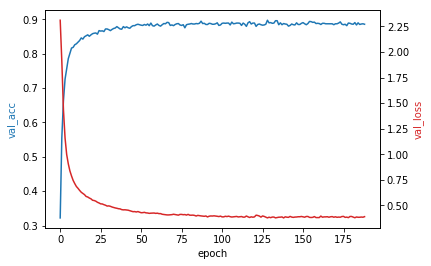

In [4]:
%%time
tag_pp = 'pp1'
tag_setup = '1-a2'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.40124908124362874
  Test accuracy: 0.8910212477974241
  Epoch: 170
CPU times: user 3min 11s, sys: 5.71 s, total: 3min 17s
Wall time: 1min 22s


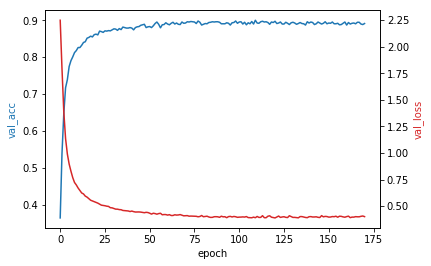

In [5]:
%%time
tag_pp = 'pp1'
tag_setup = '1-a3'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)

## b. min alpha

| min_alpha　|　1e-3　|　1e-4　|　1e-5　|
|:----|-----:|-----:|-----:|
| accuracy | 0.88 | 0.89 | 0.89 |


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.001
  epochs: 50

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.38543486864784143
  Test accuracy: 0.884852639161372
  Epoch: 183
CPU times: user 4min 47s, sys: 7 s, total: 4min 54s
Wall time: 2min 2s


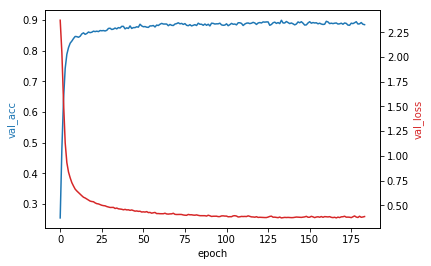

In [17]:
%%time
tag_pp = 'pp1'
tag_setup = '1-b1'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 1e-05
  epochs: 50

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3977595710280499
  Test accuracy: 0.8910212475114525
  Epoch: 168
CPU times: user 4min 52s, sys: 6.92 s, total: 4min 58s
Wall time: 2min 5s


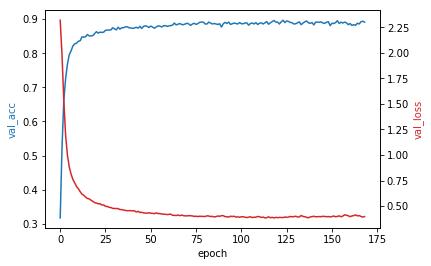

In [18]:
%%time
tag_pp = 'pp1'
tag_setup = '1-b2'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)

## c. sub-sample

| sample　|　1e-1　|　1e-2　|　1e-3　|　1e-4　|　1e-5　|　1e-6　|
|:----|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.87 | 0.87 | 0.88 | 0.87 | 0.88 | 0.81 |


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.0001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.43002194689102907
  Test accuracy: 0.8704592190105839
  Epoch: 150
CPU times: user 2min 32s, sys: 5.36 s, total: 2min 37s
Wall time: 1min 11s


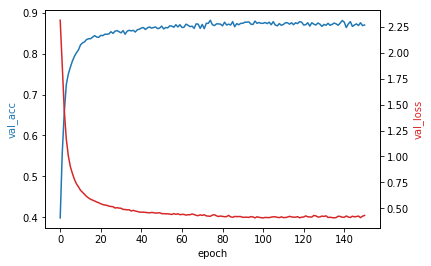

In [19]:
%%time
tag_pp = 'pp1'
tag_setup = '1-c1'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 1e-05
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4326605513293585
  Test accuracy: 0.8779986295657586
  Epoch: 204
CPU times: user 2min 3s, sys: 6.51 s, total: 2min 9s
Wall time: 1min 9s


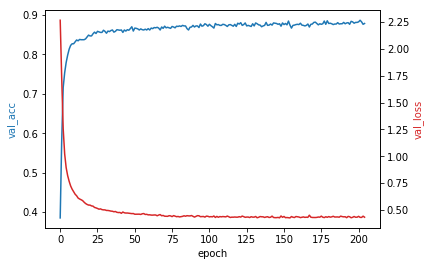

In [20]:
%%time
tag_pp = 'pp1'
tag_setup = '1-c2'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 1e-06
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.6998474613455079
  Test accuracy: 0.8135709388767554
  Epoch: 334
CPU times: user 1min 50s, sys: 8.55 s, total: 1min 58s
Wall time: 1min 17s


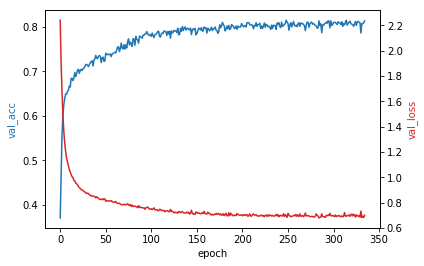

In [21]:
%%time
tag_pp = 'pp1'
tag_setup = '1-c3'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.01
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4440569968318351
  Test accuracy: 0.874571624277715
  Epoch: 229
CPU times: user 4min 33s, sys: 8.48 s, total: 4min 41s
Wall time: 2min 10s


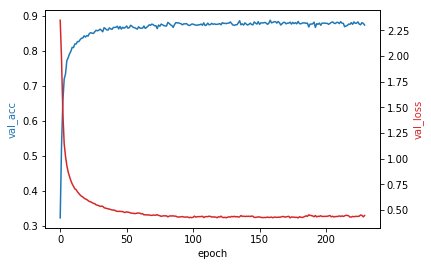

In [22]:
%%time
tag_pp = 'pp1'
tag_setup = '1-c4'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.1
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4410599122070302
  Test accuracy: 0.8745716247679519
  Epoch: 201
CPU times: user 3min 55s, sys: 5.97 s, total: 4min 1s
Wall time: 1min 38s


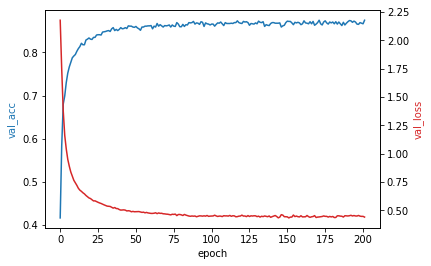

In [23]:
%%time
tag_pp = 'pp1'
tag_setup = '1-c5'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3885149725338136
  Test accuracy: 0.8841672377115737
  Epoch: 265
CPU times: user 3min 18s, sys: 7.3 s, total: 3min 26s
Wall time: 1min 31s


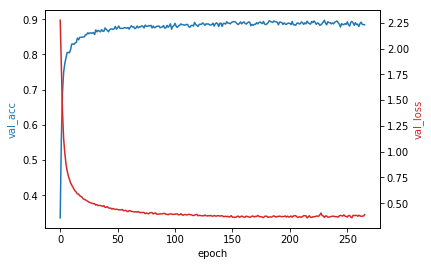

In [24]:
%%time
tag_pp = 'pp1'
tag_setup = '1-c6'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)

## d. min count

| min_count　|　1 |　2 |　5 |　10 |　20 |　40 | 100 | 200 | 1000 |
|:----|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.88 | 0.89 | 0.90 | 0.90 | 0.91 | 0.91 | 0.91 | 0.91 | 0.86 |


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 2
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.37957015035085434
  Test accuracy: 0.8910212475931587
  Epoch: 224
CPU times: user 3min 15s, sys: 7.23 s, total: 3min 22s
Wall time: 1min 38s


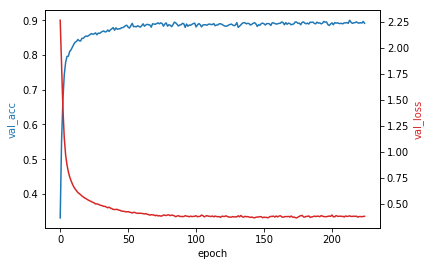

In [25]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d1'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.37668108135318823
  Test accuracy: 0.9006168609453113
  Epoch: 257
CPU times: user 3min 4s, sys: 7.76 s, total: 3min 11s
Wall time: 1min 34s


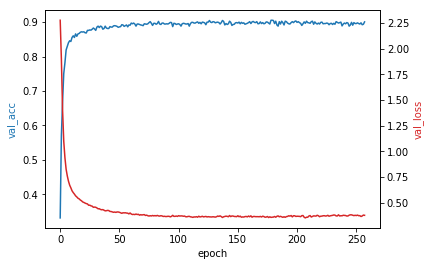

In [26]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d2'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 10
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.36195404142284326
  Test accuracy: 0.9013022621908443
  Epoch: 269
CPU times: user 2min 55s, sys: 6.41 s, total: 3min 1s
Wall time: 1min 34s


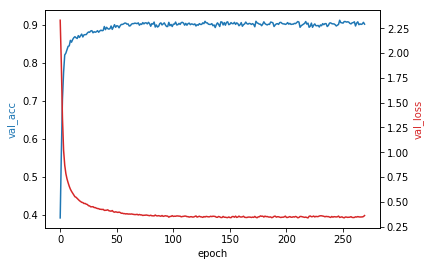

In [27]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d3'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 20
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.33455249436347756
  Test accuracy: 0.9061000687035082
  Epoch: 218
CPU times: user 2min 28s, sys: 6.14 s, total: 2min 34s
Wall time: 1min 10s


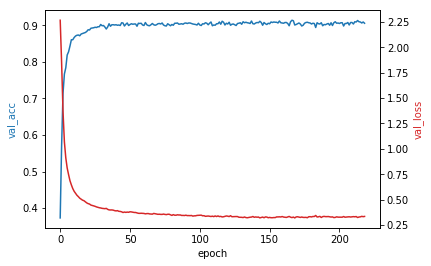

In [28]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d4'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 40
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.31840942892985774
  Test accuracy: 0.9122686775438258
  Epoch: 147
CPU times: user 2min 8s, sys: 5.01 s, total: 2min 13s
Wall time: 1min 1s


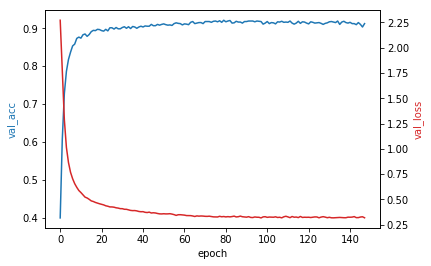

In [29]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d5'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 100
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3287959541050517
  Test accuracy: 0.9054146676622408
  Epoch: 160
CPU times: user 1min 56s, sys: 5.26 s, total: 2min 1s
Wall time: 1min


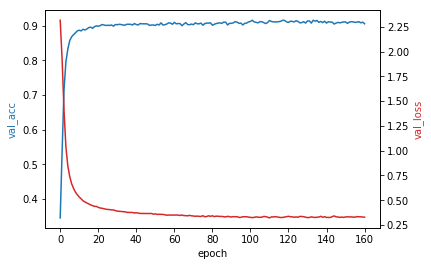

In [30]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d6'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 200
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.33897456411346333
  Test accuracy: 0.9102124740931986
  Epoch: 188
CPU times: user 1min 46s, sys: 5.47 s, total: 1min 51s
Wall time: 56.7 s


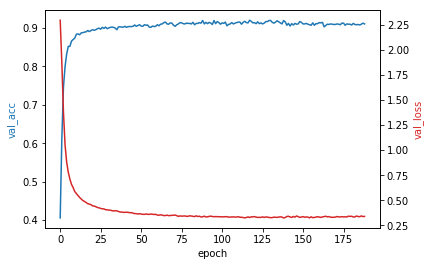

In [31]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d7'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)


Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 1000
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4512097496255936
  Test accuracy: 0.8642906102928256
  Epoch: 192
CPU times: user 1min 24s, sys: 5.7 s, total: 1min 29s
Wall time: 52.7 s


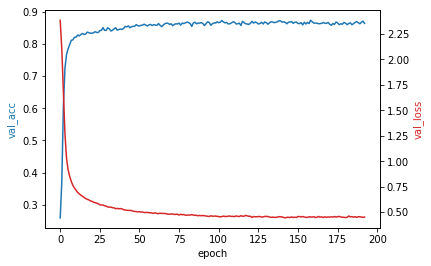

In [32]:
%%time
tag_pp = 'pp1'
tag_setup = '1-d8'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)

## e. window size

| window　|　2 | 4 | 8 | 15 | 30 | 50 |
|:----|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.90 | 0.90 | 0.90 | 0.90 | 0.90 | 0.90 |


--- 1-e1 ---

Doc2Vec training parameters:
  vector_size: 50
  window: 2
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.356805211513969
  Test accuracy: 0.8992460590261887
  Epoch: 167

--- 1-e2 ---

Doc2Vec training parameters:
  vector_size: 50
  window: 4
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3711005628435803
  Test accuracy: 0.8971898564334763
  Epoch: 189

--- 1-e3 ---

Doc2Vec training parameters:
  vector_size: 50
  window: 8
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3614134975007497
  Test accuracy: 0.8978752568210945
  Epoch: 194

--- 1-e4 ---

Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 5
  sample: 0

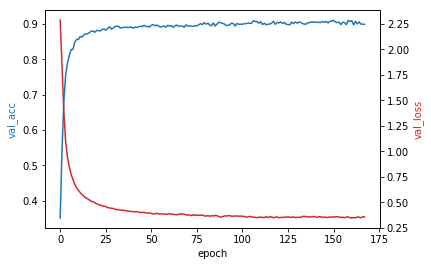

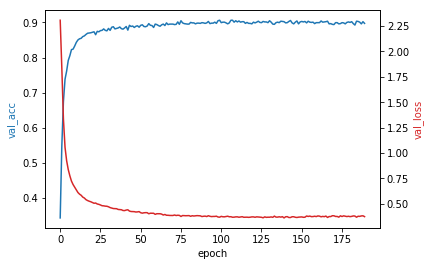

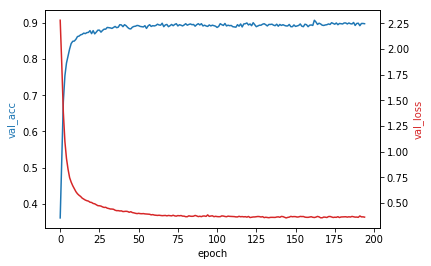

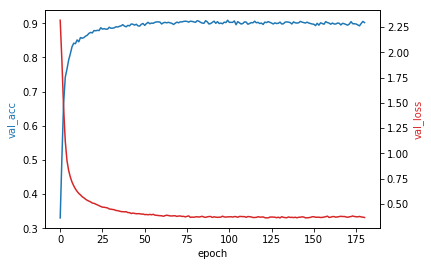

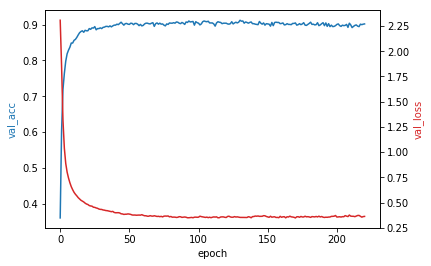

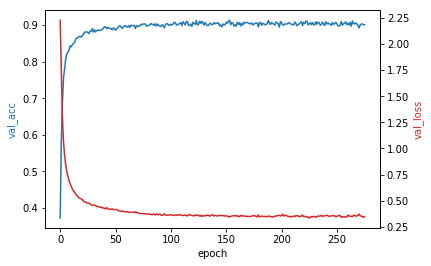

In [39]:
tag_pp = 'pp1'
tag_setups = ['1-e%d' % i for i in range(1, 7)]

for tag_setup in tag_setups:
    print('\n--- %s ---' % tag_setup)
    save_path='results/%s' % tag_setup

    ep = ExpPar(tag_pp, tag_setup)
    model = ep.train_model()
    ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                      dic_category_map=ep.dic_category_map)
    ed.eval_sv(save_path=save_path)


## f. vector size

| vector_size　|　20 |　50 |　100 |　200 |　300 |　400 |
|:----|-----:|-----:|-----:|-----:|-----:|-----:|
| accuracy | 0.85 | 0.90 | 0.91 | 0.91 | 0.90 | 0.90 |


--- 1-f1 ---

Doc2Vec training parameters:
  vector_size: 20
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.4251726751379807
  Test accuracy: 0.8485263883046208
  Epoch: 241


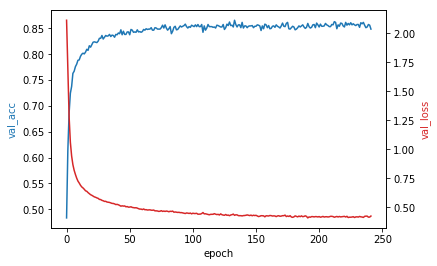


--- 1-f2 ---

Doc2Vec training parameters:
  vector_size: 50
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3487506195892611
  Test accuracy: 0.8999314602717216
  Epoch: 186


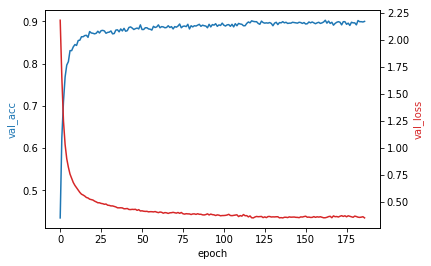


--- 1-f3 ---

Doc2Vec training parameters:
  vector_size: 100
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.35771565928779453
  Test accuracy: 0.9095270731336372
  Epoch: 137


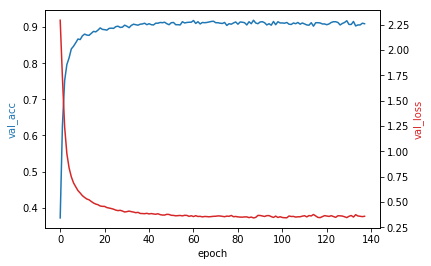


--- 1-f4 ---

Doc2Vec training parameters:
  vector_size: 200
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3999427129872618
  Test accuracy: 0.9067854697856289
  Epoch: 113


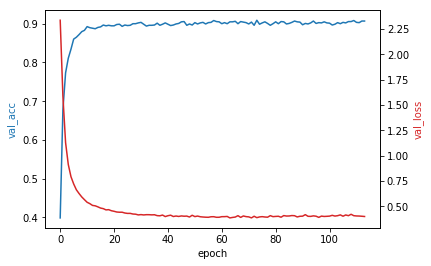

In [2]:
tag_pp = 'pp1'
tag_setups = ['1-f%d' % i for i in range(1, 5)]

for tag_setup in tag_setups:
    print('\n--- %s ---' % tag_setup)
    save_path='results/%s' % tag_setup

    ep = ExpPar(tag_pp, tag_setup)
    model = ep.train_model()
    ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                      dic_category_map=ep.dic_category_map)
    ed.eval_sv(save_path=save_path)



--- 1-f5 ---

Doc2Vec training parameters:
  vector_size: 300
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.40219607250669215
  Test accuracy: 0.9047292664167078
  Epoch: 105


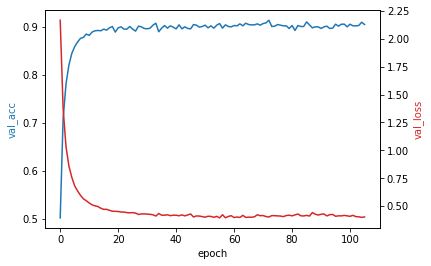


--- 1-f6 ---

Doc2Vec training parameters:
  vector_size: 400
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.44092900128786167
  Test accuracy: 0.9013022619048727
  Epoch: 132


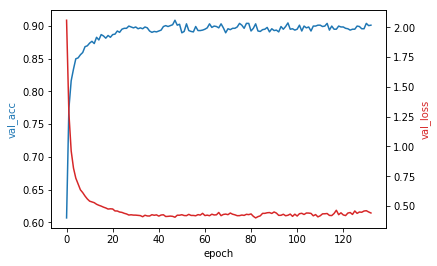

In [4]:
tag_pp = 'pp1'
tag_setups = ['1-f5', '1-f6']

for tag_setup in tag_setups:
    print('\n--- %s ---' % tag_setup)
    save_path='results/%s' % tag_setup

    ep = ExpPar(tag_pp, tag_setup)
    model = ep.train_model()
    ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                      dic_category_map=ep.dic_category_map)
    ed.eval_sv(save_path=save_path)

## optimized parameters


Doc2Vec training parameters:
  vector_size: 100
  window: 15
  min_count: 5
  sample: 0.001
  alpha: 0.025
  min_alpha: 0.0001
  epochs: 30

MLP data:
   5832 train samples
   1459 test samples

MLP score:
  Test loss: 0.3860374952196013
  Test accuracy: 0.908841672746019
  Epoch: 160


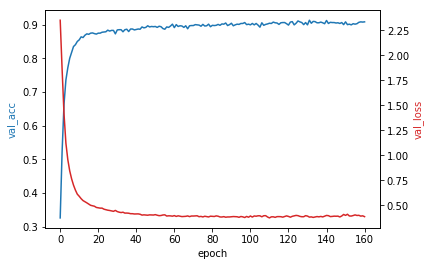

CPU times: user 2min 52s, sys: 5.23 s, total: 2min 57s
Wall time: 1min 15s


In [3]:
%%time
tag_pp = 'pp1'
tag_setup = '1-opt'
save_path='results/%s' % tag_setup

ep = ExpPar(tag_pp, tag_setup)
model = ep.train_model()
ed = evaluation_docs.evaluation_labeled_docs(model, ep.tagged_words_list, n_clusters=20, 
                                                                                  dic_category_map=ep.dic_category_map)
ed.eval_sv(save_path=save_path)